In [1]:

#loading in dependencies, run this on greenlandMapping - future make new env
%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
import glob
import shapely
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

In [2]:
#paths
centreline_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/flowlines/glacier0001_iter03.shp"
terminus_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0781/collated/JakbobshavnIsbraeTerminus.shp"
velocity_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0766/JakobshavnIsbraeVelocitySeriesNew.nc"
centreline_maqit_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/centreline1.csv"

#read in velocity 
velocity = xr.open_dataset(velocity_path)

#read in centreline + make sure coordinate system = EPSG:3413
centreline = gpd.read_file(centreline_path)
centreline = centreline.to_crs("EPSG:3413")

centreline_shape = centreline.geometry.iloc[0]

#read in terminus
terminus = gpd.read_file(terminus_path)
terminus = terminus.to_crs("EPSG:3413")

terminus = terminus.rename(columns={"SourceDate": "Date"}) #rename for simplicity
terminus["Date"] = pd.to_datetime(terminus["Date"]) #make sure it is in datetime 
terminus = terminus.sort_values("Date").reset_index(drop=True) #sort in chronological 

In [3]:
#sanity check for geospatial alignment
print(centreline.crs)
print(terminus.crs)

EPSG:3413
EPSG:3413


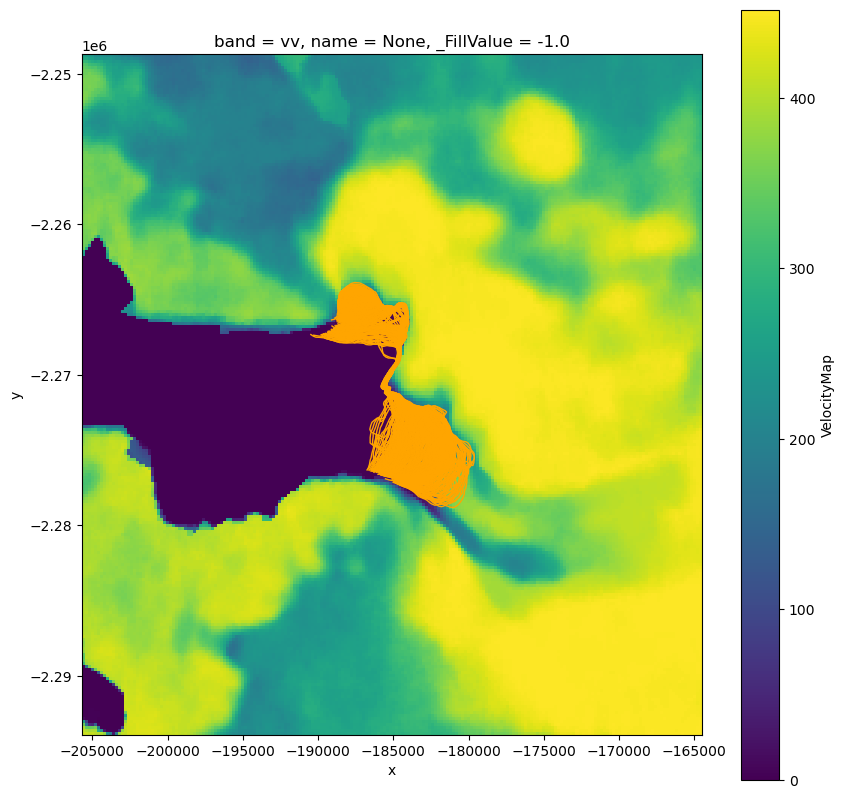

In [4]:
#plotting valid velocity values AND terminus (set)
    #yellow is has more, purple has less 
vel_band = velocity["VelocityMap"].isel(band=2)

valid_count = vel_band.count(dim="time")  #points with "valid" non NaN values

fig, ax = plt.subplots(figsize=(10, 10))

valid_count.plot(
    ax=ax,
    x="x",
    y="y",
    add_colorbar=True,
)

terminus.plot(
     ax=ax,
     facecolor="none",
     edgecolor="orange",
     linewidth=1,
)

plt.show()


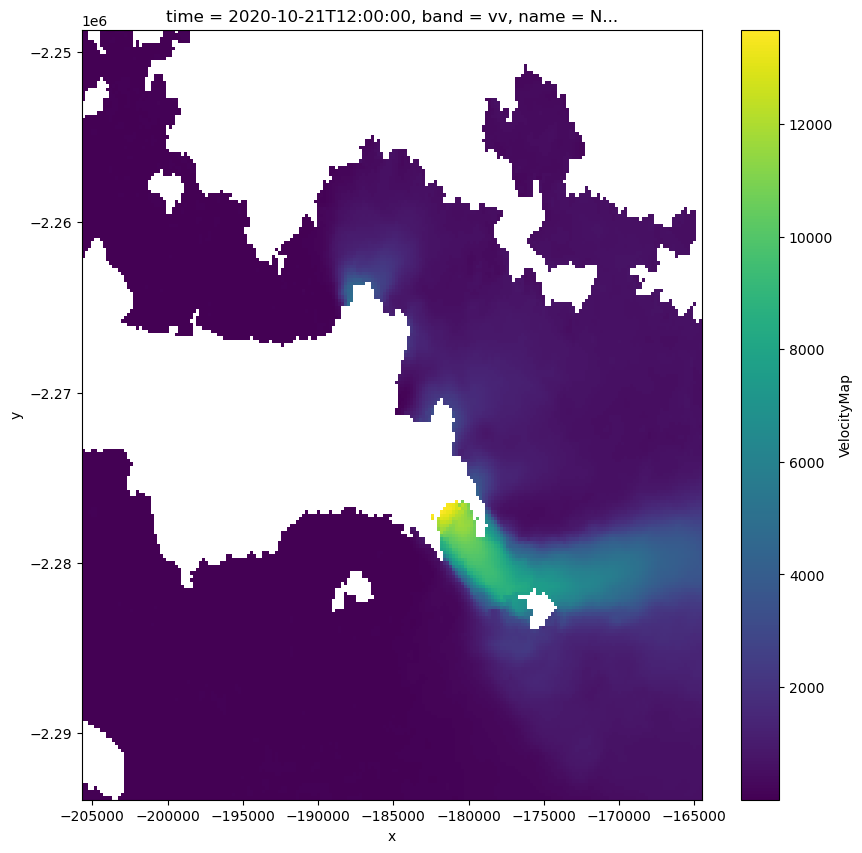

In [5]:
#velocity visual
    #there are 250 velocity 
sampletime = 300
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

x_vals = velocity["x"].values
y_vals = velocity["y"].values

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)

plt.show()

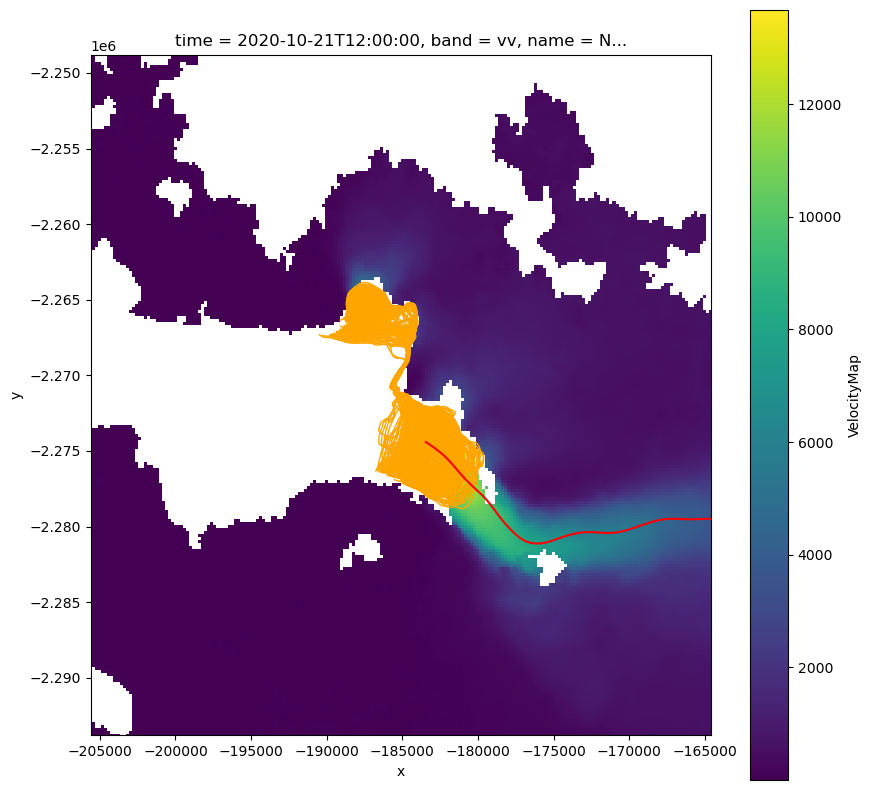

In [6]:
#visualising velocity, terminus and centerline on one
sampletime = 300
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)

terminus.plot(
    ax=ax,
    facecolor="none",
    edgecolor="orange",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax,
    color="red",
    linewidth=1.5,
)

ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(y_vals.min(), y_vals.max())
ax.set_aspect("equal")

plt.show()


velocity: 2017-09-25 12:00:00
terminus: 2017-09-25 00:00:00


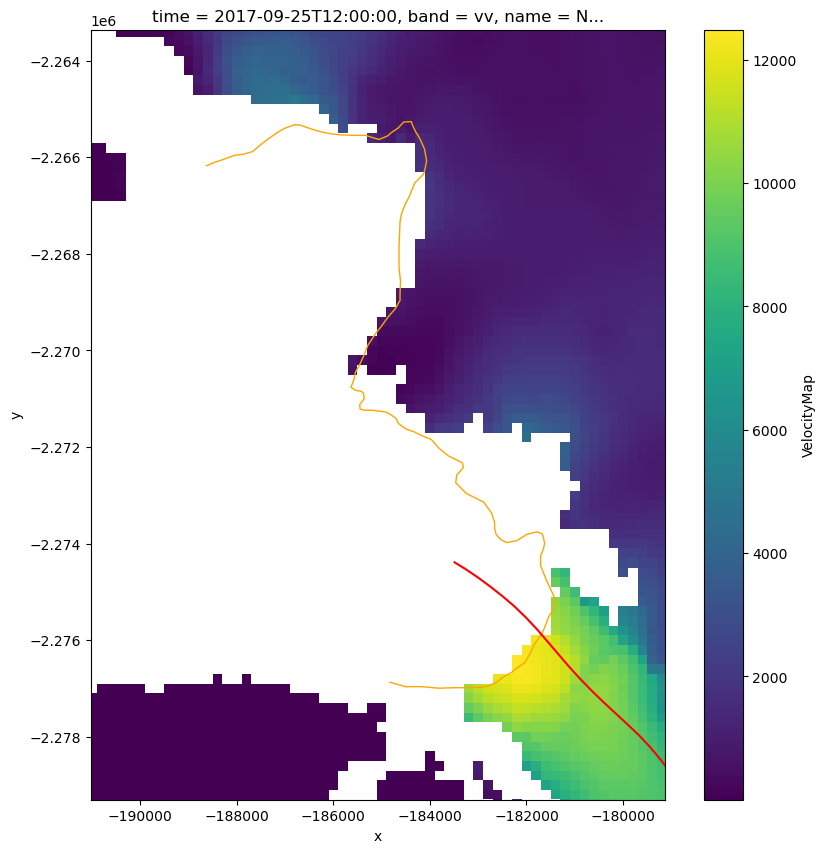

In [7]:
#visualising velocity, terminus and centerline on one with a non valid intersection value
    #velocity: 2017-10-01 12:00:00
    #terminus: 2017-10-01 00:00:00  
sampletime = 113

vel_time = velocity["time"].isel(time=sampletime).values 
nearest_time = (terminus["Date"]- vel_time).abs().idxmin() #calc nearest terminus(Date) and vel time
term_time = terminus.loc[[nearest_time]] #this selects the terminus geometry from the nearest_time

vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

#CHECK:are these the same day/near?
t_vel = pd.to_datetime(vel_time)
t_term = term_time["Date"].iloc[0]
print("velocity:", t_vel)
print("terminus:", t_term)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)

term_time.plot(
    ax=ax,
    facecolor="none",
    edgecolor="orange",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax,
    color="red",
    linewidth=1.5,
)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()

velocity: 2017-09-25 12:00:00
terminus: 2017-09-25 00:00:00


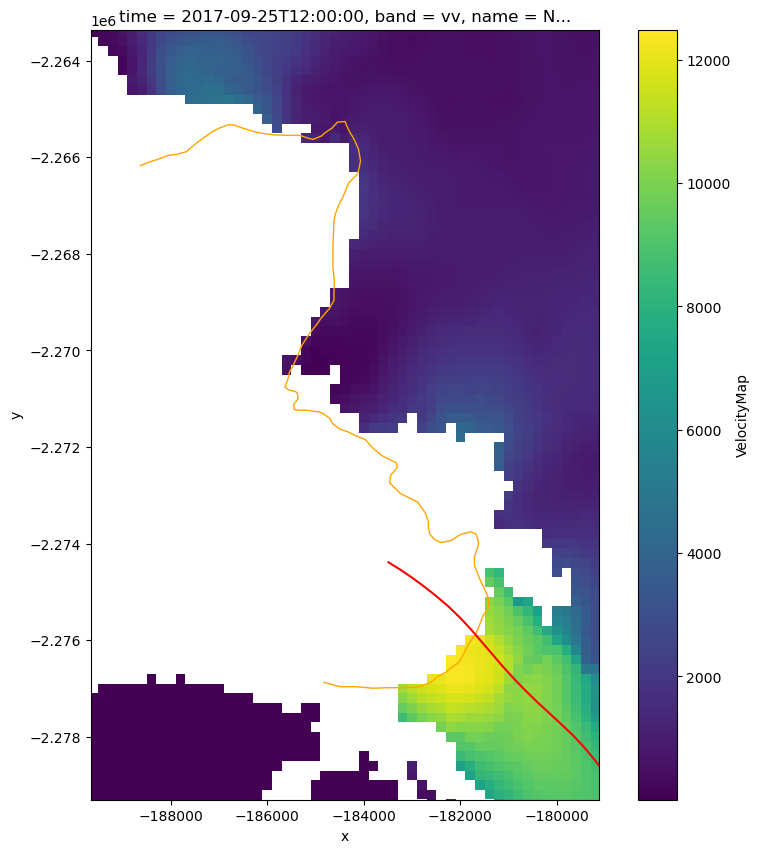

In [71]:
#visualising velocity, terminus and centerline on one with a  valid intersection value
    #velocity: 2017-10-01 12:00:00
    #terminus: 2017-10-01 00:00:00  
sampletime = 113

vel_time = velocity["time"].isel(time=sampletime).values 
nearest_time = (terminus["Date"]- vel_time).abs().idxmin() #calc nearest terminus(Date) and vel time
term_time = terminus.loc[[nearest_time]] #this selects the terminus geometry from the nearest_time

vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

#CHECK:are these the same day/near?
t_vel = pd.to_datetime(vel_time)
t_term = term_time["Date"].iloc[0]
print("velocity:", t_vel)
print("terminus:", t_term)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(
    ax=ax,
    x="x",         
    y="y",         
    add_colorbar=True,
)

term_time.plot(
    ax=ax,
    facecolor="none",
    edgecolor="orange",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax,
    color="red",
    linewidth=1.5,
)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()

In [8]:
#originally there were 111 Nan out of 357

# finding the intersection between the centerline and the terminus
def intersection(centreline, terminus_line):
    intersect = centreline.intersection(terminus_line)

    if intersect.is_empty:
        return None
    
    if intersect.geom_type == "MultiPoint": #if there is more than one intersect put the point closes to the centre of the terminus line
        return min(intersect.geoms, key = lambda p: p.distance(terminus_line.centroid))
    
    return intersect
 
pts = []
for i in range(len(terminus)):
    terminus_line = terminus.geometry.iloc[i]
    pt = intersection(centreline_shape, terminus_line) #geometric intersection between centerline_shape and terminus_line 
    pts.append(pt)

terminus["intersect_points"] = pts

#check to see how many are None
none_vals = terminus["intersect_points"].isna().sum()
print(none_vals)

total = len(terminus["intersect_points"])
print(total)

111
357


In [ ]:
#adding buffer when applicable 
# finding the intersection between the centerline and the terminus
def intersection(centreline, terminus_line):
    intersect = centreline.intersection(terminus_line)

    if intersect.is_empty:
        return intersect
    
    if intersect.geom_type == "MultiPoint": #if there is more than one intersect put the point closes to the centre of the terminus line
        return min(intersect.geoms, key = lambda p: p.distance(terminus_line.centroid))
    
    return intersect

buffer_dist = 1000
pts = []
used_buffer = []   # list to check if buffer was applied or not

for i in range(len(terminus)):
    terminus_line = terminus.geometry.iloc[i]
    inter = intersection(centreline_shape, terminus_line) #intersection between centreline and terminus -- NO BUFFER

#if need buffer we apply, i.e., if return = empty 
    if inter.is_empty:
        inter = centreline_shape.intersection(terminus_line.buffer(buffer_dist))
        used_buffer.append(True)
    else:
        used_buffer.append(False)

# need to convert to a point - for compatability??
    if inter.is_empty:
        pt = inter 
    elif inter.geom_type == "Point":
        pt = inter
    elif inter.geom_type == "MultiPoint":
        pt = min(inter.geoms, key=lambda p: p.distance(terminus_line.centroid))  #if there is more than one intersect put the point closes to the centre of the terminus line
    elif inter.geom_type == "LineString":
        c = terminus_line.centroid
        pt = inter.interpolate(inter.project(c))

    pts.append(pt)


terminus["intersect_points"] = pts
terminus["intersect_points"] = gpd.GeoSeries(terminus["intersect_points"],crs=terminus.crs)
terminus["buffer_was_used"] = used_buffer

#check to see how many are None
empty_vals = terminus["intersect_points"].is_empty.sum()
print(empty_vals)

total = len(terminus["intersect_points"])
print(total)

47
357


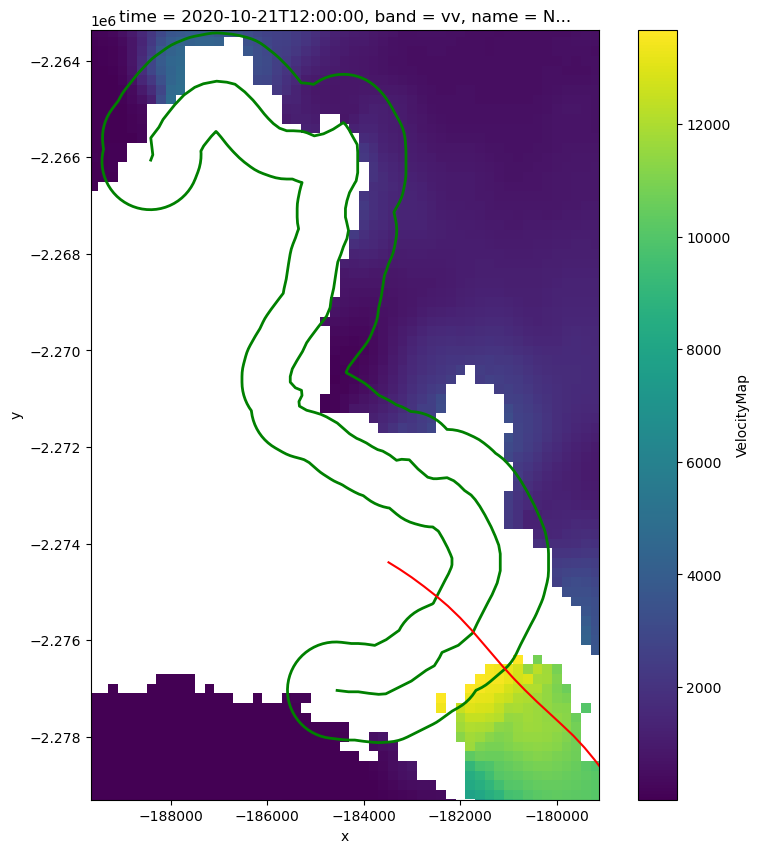

In [72]:
#visualisation w the buffer
sampletime = 300
buffer_dist = 1000  # meters

vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime).assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

# pick nearest terminus to this velocity time
vel_time = velocity["time"].isel(time=sampletime).values
nearest_idx = (terminus["Date"] - vel_time).abs().idxmin()
term_one = terminus.loc[[nearest_idx]]
term_line = term_one.geometry.iloc[0]

# buffer polygon
term_buffer = term_line.buffer(buffer_dist)
term_buffer_gs = gpd.GeoSeries([term_buffer], crs=terminus.crs)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(ax=ax, x="x", y="y", add_colorbar=True)

# buffer
term_buffer_gs.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=2)

# terminus line + centreline
term_one.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=2)
gpd.GeoSeries([centreline_shape], crs=terminus.crs).plot(ax=ax, color="red", linewidth=1.5)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()


In [ ]:

vel_band = velocity["VelocityMap"].isel(band=2).assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)
vel_times = pd.to_datetime(vel_band["time"].values)

def nearest_buffer(vel_slice2, x0, y0, buffer=1000): #xarray slicing depends on whether y coordinates increase or decrease so check direction?
    """nearest non-nan value to (x0,y0) within a buffer."""
    # subset window (handle y increasing/decreasing)
    if float(vel_slice2["y"][0]) < float(vel_slice2["y"][-1]):   # y increasing
        sub = vel_slice2.sel(x=slice(x0-buffer, x0+buffer),
                       y=slice(y0-buffer, y0+buffer))
    else:                                            # y decreasing
        sub = vel_slice2.sel(x=slice(x0-buffer, x0+buffer),
                       y=slice(y0+buffer, y0-buffer))
    #^^^ this is the checking direction thing 

    vals = sub.values
    if not np.isfinite(vals).any(): #if whole "buffer" window is Nan then return Nan 
        return np.nan

    xs = sub["x"].values #coordinate assignment
    ys = sub["y"].values
    X, Y = np.meshgrid(xs, ys)

    mask = np.isfinite(vals) #only conisdering valid pixels 
    d2 = (X[mask] - x0)**2 + (Y[mask] - y0)**2 #basically like the distance equation
    k = np.argmin(d2)

    return float(vals[mask][k]) #return value at taht closest valid pixel 


In [68]:
buffer_dist = 1000 

vel_nearest = []
matched_vel_time = []

for i in range(len(terminus)):
    pt = terminus["intersect_points"].iloc[i]

    # skip if no intersection point
    if pt.is_empty:
        vel_nearest.append(np.nan)
        matched_vel_time.append(pd.NaT)
        continue

    # terminus date
    t_term = pd.to_datetime(terminus["Date"].iloc[i])

    # nearest velocity time index
    j = int(np.argmin(np.abs(vel_times - t_term)))
    matched_vel_time.append(vel_times[j])

    # velocity slice at that nearest time
    vel_slice = vel_band.isel(time=j)

    # nearest valid velocity within buffer around the point
    v = nearest_buffer(vel_slice, pt.x, pt.y, buffer=buffer_dist)
    vel_nearest.append(v)

terminus["vel_nearest_buffer"] = vel_nearest
terminus["matched_vel_time"] = matched_vel_time


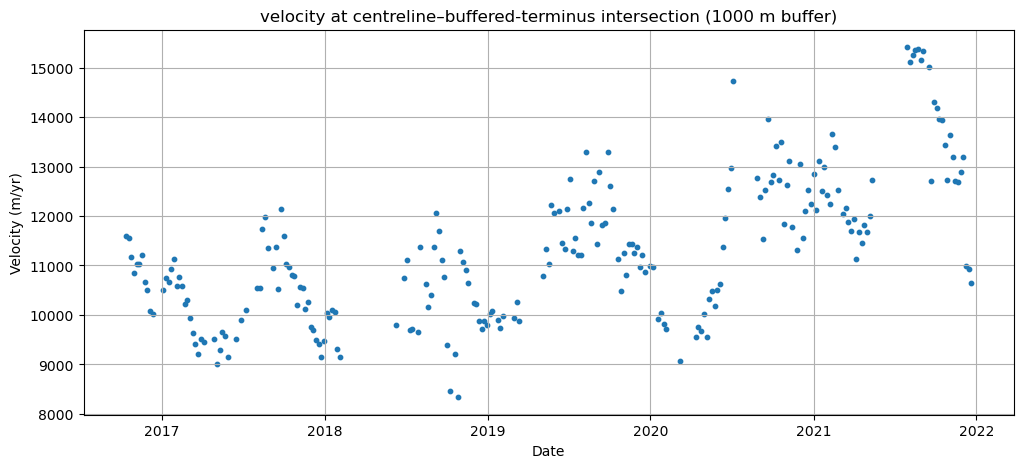

In [57]:
plt.figure(figsize=(12, 5))
plt.scatter(terminus["Date"], terminus["vel_nearest_buffer"], s=10)
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("velocity at centreline–buffered-terminus intersection (1000 m buffer)")
plt.grid(True)
plt.show()

In [ ]:
centreline_maqit = pd.read_csv(centreline_maqit_path, skiprows=1)


centreline_maqit["Date"] = pd.to_datetime(
    dict(Year=centreline_maqit["Year"],
        Month=centreline_maqit["Month"],
        Day=centreline_maqit["Day"])
)

cl = centreline_maqit[[
    "Date",
    "Terminus Position on flowline",
    "Terminus change (m)"
]]

cl = cl.rename(columns = {
    "Terminus Position on flowline": "L", 
    "Terminus change (m)": "del_L"
})

cl

#merge to terminus set

terminus = terminus.merge(cl)
terminus = terminus.sort_values("Date").reset_index(drop=True)


In [60]:
#dt calc
terminus["dt_days"] = terminus["Date"].diff().dt.days
terminus["dt_years"] = terminus["dt_days"] / 365.25

#dt calc
terminus["dL"] = terminus["L"].diff()
terminus["dLdt"] = terminus["dL"] / terminus["dt_years"]

In [61]:
terminus["calving"] = terminus["vel_nearest_buffer"] - terminus["dLdt"]

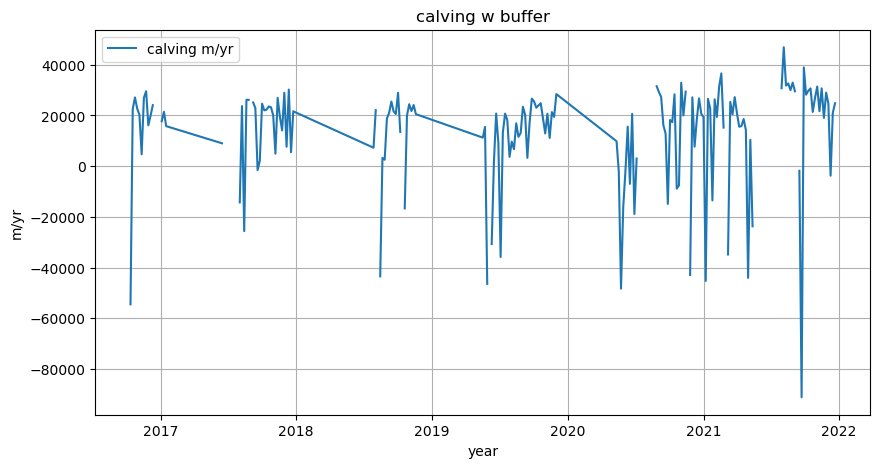

In [70]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(terminus["Date"], terminus["calving"],  label = "calving m/yr" )
plt.title("calving w buffer")
ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


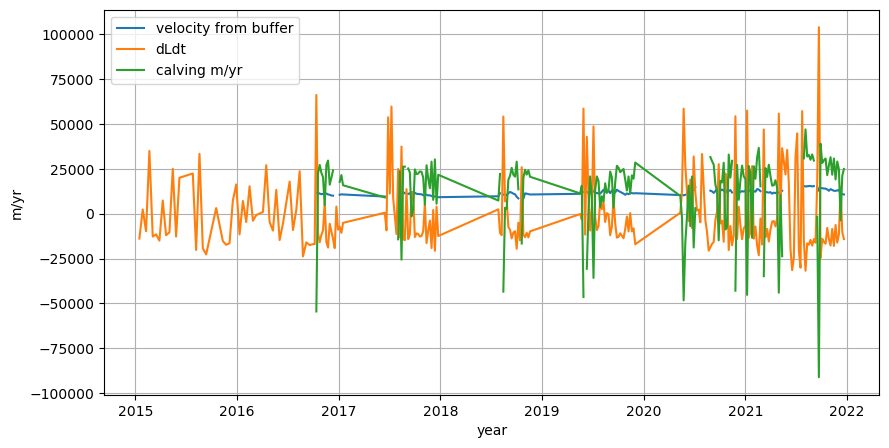

In [65]:

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(terminus["Date"], terminus["vel_nearest_buffer"], label = "velocity from buffer" )
ax.plot(terminus["Date"], terminus["dLdt"], label = "dLdt")
ax.plot(terminus["Date"], terminus["calving"],  label = "calving m/yr" )

ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


In [22]:
#this is was original attempt using u = 1500 m/yr

In [24]:
terminus

,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry,intersect_points,velocity_intersection,buffer,buffer_intersect_points,velocity_buffer_pt,L,del_L,dt_days,dt_years,dL,dLdt,calving
0,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399....",POINT (-182302.33390831872 -2275255.0299488134),NaN,"POLYGON ((-189306.988 -2265055.099, -189263.69...",POINT (-182388.11269200183 -2275182.1060847165),NaN,1492.80,NaN,NaN,NaN,NaN,NaN,NaN
1,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629....",POINT (-182654.5811722098 -2274965.15839306),NaN,"POLYGON ((-189629.49 -2264978.882, -189624.272...",POINT (-182480.64491905228 -2275103.4408570193),NaN,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,NaN
2,SEN1_NSIDC_0723_V2_20150125_20150205,S1A_090_004362,2015-01-27,1,3,"LINESTRING (-186068.771 -2276605.242, -185814....",POINT (-182594.66389060495 -2275012.2059813403),NaN,"POLYGON ((-188545.249 -2264094.934, -188509.41...",POINT (-182603.700575338 -2275005.110295232),NaN,1112.70,76.181,12.0,0.032854,76.20,2319.337500,NaN
3,SEN1_NSIDC_0723_V2_20150206_20150217,S1A_090_004537,2015-02-08,0,3,"LINESTRING (-184745.971 -2277111.477, -184132....",POINT (-182850.18781654522 -2274815.9306988167),NaN,"POLYGON ((-187187.876 -2265453.1, -187199.666 ...",POINT (-182692.5444580805 -2274935.3492796356),NaN,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,NaN
4,SEN1_NSIDC_0723_V4_20150218_20150301,S1A_090_004712,2015-02-20,0,3,"LINESTRING (-185068.764 -2276846.893, -184507....",POINT (-181981.37287173132 -2275562.417235696),NaN,"POLYGON ((-189440.183 -2265065.256, -189427.36...",POINT (-182289.13461320315 -2275266.251180473),NaN,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,SEN1_NSIDC_0723_V4_20211125_20211130,S1A_090_040762,2021-11-27,0,3,"LINESTRING (-185111.097 -2276688.143, -184878....",POINT (-182377.55969028606 -2275191.0775999315),NaN,"POLYGON ((-188264.545 -2265390.539, -188217.16...",POINT (-182376.54909323467 -2275191.9367476003),NaN,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,NaN
242,SEN1_NSIDC_0723_V4_20211201_20211206,S1B_090_029866,2021-12-03,1,3,"LINESTRING (-185164.014 -2276666.976, -184867....",POINT (-182522.16672362867 -2275069.1314087305),NaN,"POLYGON ((-186269.536 -2271567.172, -186270.88...",POINT (-182528.26744955353 -2275064.341063878),NaN,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,NaN
243,SEN1_NSIDC_0723_V4_20211207_20211212,S1A_090_040937,2021-12-09,1,3,"LINESTRING (-184931.18 -2276910.393, -184380.8...",POINT (-182337.44590745497 -2275225.1798793296),NaN,"POLYGON ((-188690.355 -2265152.386, -188460.66...",POINT (-182424.5919654968 -2275151.0936423796),NaN,1446.70,241.830,6.0,0.016427,241.80,14719.575000,NaN
244,SEN1_NSIDC_0723_V4_20211213_20211218,S1B_090_030041,2021-12-15,1,3,"LINESTRING (-184793.596 -2276973.893, -184497....",POINT (-182464.42914589713 -2275117.2265134137),NaN,"POLYGON ((-186345.708 -2271375.76, -186360.341...",POINT (-182499.22022296957 -2275087.649272198),NaN,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,NaN


In [23]:
#change to date time (this is a thing)
terminus["Date"] = pd.to_datetime(
    dict(year = terminus["Year"],
        month = terminus["Month"],
        day = terminus["Day"])
)

terminus = terminus.rename(columns = {
    "Terminus Position on flowline": "L",
    "Terminus change (m)": "del_L"
})

#for simplicity i just want these (for now, tbd)
terminus_columns = ["Date", "L", "del_L"]
terminus = terminus[terminus_columns].sort_values("Date").reset_index(drop= True)


KeyError: 'Year'

In [ ]:
#terminus df 
df = terminus.copy().sort_values("Date").reset_index(drop=True)

#dt calc
df["dt_days"] = df["Date"].diff().dt.days
df["dt_years"] = df["dt_days"] / 365.25

#dt calc
df["dL"] = df["L"].diff()
df["dLdt_per_year"] = df["dL"] / df["dt_years"]

df[["Date", "L", "dt_days", "dL", "dLdt_per_year"]].head(10)

#dLdt = dL ( 6 days) - terminus change between data / dt (per year)



,Date,L,dt_days,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN
1,2015-01-15,1036.50,12.0,-456.30,-13888.631250
2,2015-01-27,1112.70,12.0,76.20,2319.337500
3,2015-02-08,790.49,12.0,-322.21,-9807.266875
4,2015-02-20,1937.40,12.0,1146.91,34909.073125
5,2015-03-04,1518.00,12.0,-419.40,-12765.487500
6,2015-03-16,1139.70,12.0,-378.30,-11514.506250
7,2015-03-28,645.19,12.0,-494.51,-15051.648125
8,2015-04-09,884.89,12.0,239.70,7295.868750
9,2015-04-21,489.40,12.0,-395.49,-12037.726875


In [ ]:
#so w my velocity i should pick a point on the terminus right 
# - probably where it intersects the centreline

centreline.length

0    564300.353452
dtype: float64

In [ ]:
vv = velocity["VelocityMap"].sel(band="vv")
print("min, max:", float(vv.min()), float(vv.max()))

min, max: 0.006762796081602573 16439.25


In [ ]:
xmin, xmax = float(vv.x.min()), float(vv.x.max())
ymin, ymax = float(vv.y.min()), float(vv.y.max())
print(xmin, xmax, ymin, ymax)

-194000.0 -170000.0 -2288000.0 -2264000.0


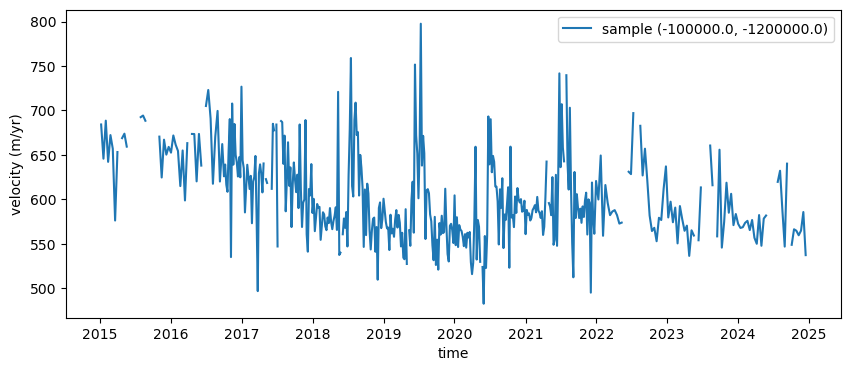

In [ ]:
x0 = -100000.0
y0 = -1200000.0

label = 'sample'

vv_band = velocity["VelocityMap"].sel(band='vv')

vel_sample_pt = vv_band.sel(x=x0, y=y0, method='nearest')
df_selected_point = vel_sample_pt.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_selected_point['time'], df_selected_point['VelocityMap'], label=f'{label} ({x0}, {y0})')
plt.xlabel('time')
plt.ylabel('velocity (m/yr)')
plt.legend()
plt.show()

#should clean this? claire has a notebook on this 
#should also find a way to pick a point near the terminsu 
# no needto interpooalte

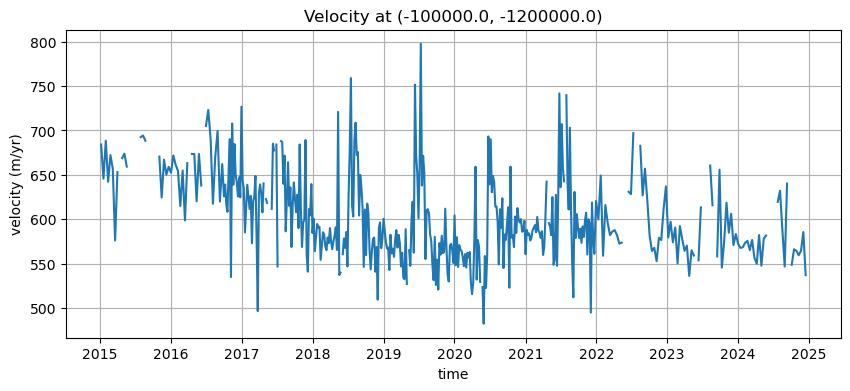

In [ ]:

#random upstream point 
sample1 = vv.sel(x=-170000, y=-2200000, method="nearest")  # DataArray with time dim
df_sample = sample1.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_sample["time"], df_sample["VelocityMap"])
plt.xlabel("time")
plt.ylabel("velocity (m/yr)")
plt.title(f"Velocity at ({x0}, {y0})")
plt.grid()
plt.show()



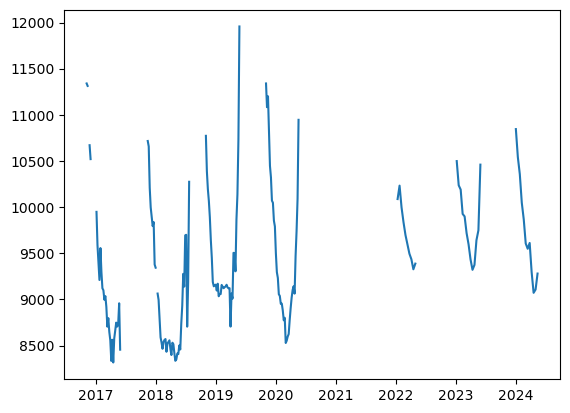

In [ ]:
#at date = 1
x_pt = df.loc[0, "x"]
y_pt = df.loc[0, "y"]

vel_pt = vv.sel(x=x_pt, y=y_pt, method="nearest")
df_vel = vel_pt.to_dataframe().reset_index()
plt.plot(df_vel["time"], df_vel["VelocityMap"])

In [ ]:
u_vals = []       # velocity at intersection (m/yr)

for _, row in df.iterrows():
    x = row["x"]
    y = row["y"]
    t = row["Date"]

    if pd.isna(x) or pd.isna(y) or pd.isna(t):
        u_vals.append(np.nan)
        continue

    v_intersect = vv.sel(time=t, x=x, y=y, method="nearest").values

    if np.isnan(v_intersect):
        u_vals.append(np.nan)
    else:
        u_vals.append(float(v_intersect))


df["u_per_yr"] = u_vals

In [ ]:
# assuming a veloicty of 1500 m/a to begin the calving series

u_constant = 1500.0 #unit is m /year 

df["u_per_year"] = u_constant


,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving,vel_date,vel_dt_days
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN,2015-01-06 12:00:00,3.5
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250,2015-01-18 12:00:00,3.5
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500,2015-01-30 12:00:00,3.5
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875,2015-02-11 12:00:00,3.5
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125,2015-02-23 12:00:00,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500,2021-11-27 12:00:00,0.5
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000,2021-12-03 12:00:00,0.5
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000,2021-12-09 12:00:00,0.5
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000,2021-12-15 12:00:00,0.5


In [ ]:
df["calving"] = df["u_per_year"] - df["dLdt_per_year"]

#calving unit is m /yr
# calving rate > 0 : terminus advance  (due to velocity)
# calving rate < 0 : terminus retreat (due to calving)

In [ ]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000


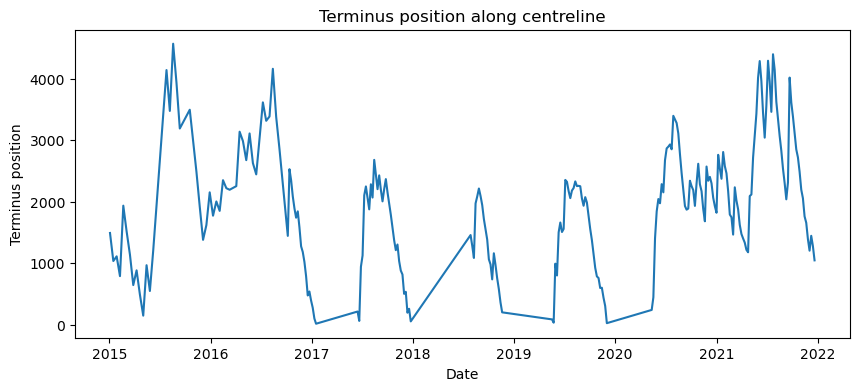

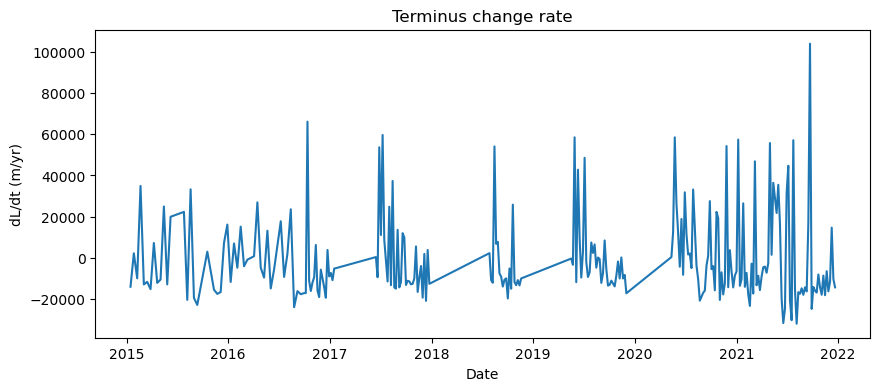

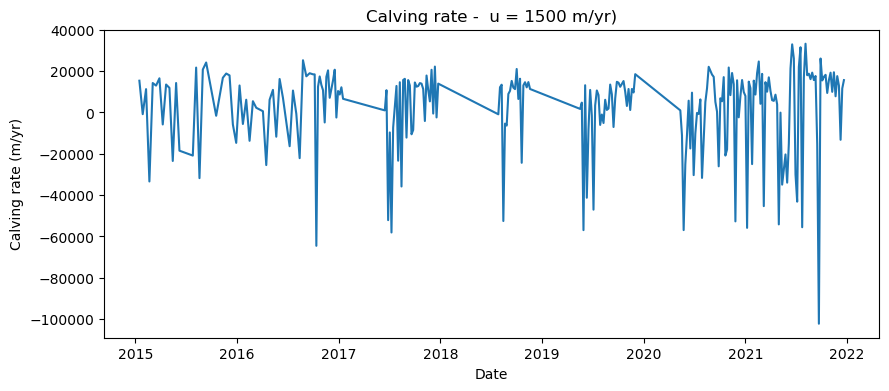

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["L"])
plt.xlabel("Date")
plt.ylabel("Terminus position")
plt.title("Terminus position along centreline")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["dLdt_per_year"])
plt.xlabel("Date")
plt.ylabel("dL/dt (m/yr)")
plt.title("Terminus change rate")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["calving"])
plt.xlabel("Date")
plt.ylabel("Calving rate (m/yr)")
plt.title("Calving rate -  u = 1500 m/yr)")
plt.show()